In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import ast

import warnings
warnings.filterwarnings('ignore')


#Read cleaned and wrangled data
twitter = pd.read_csv("twitter_cleaned.csv", index_col = 0)
instagram = pd.read_csv("instagram_cleaned.csv", index_col = 0)
facebook = pd.read_csv("facebook_cleaned.csv", index_col = 0)

#Ensure that tokens are read as lists, not strings
twitter['tokens'] = twitter['tokens'].map(ast.literal_eval)
instagram['tokens'] = instagram['tokens'].map(ast.literal_eval)
facebook['tokens'] = facebook['tokens'].map(ast.literal_eval)

#STOPWORDS & STEMMING
stopwords = nltk.corpus.stopwords.words("english") 
ps = PorterStemmer()

#can change to WordNetLemmatizer().lemmatize(word)
for i, tokenset in twitter.tokens.items():
    twitter.tokens[i] = [ps.stem(word) for word in tokenset if word.lower() not in stopwords]
for j, tokenset in instagram.tokens.items():
    instagram.tokens[j] = [ps.stem(word) for word in tokenset if word.lower() not in stopwords]
for k, tokenset in facebook.tokens.items():
    facebook.tokens[k] = [ps.stem(word) for word in tokenset if word.lower() not in stopwords]

In [2]:
#BUILDING CORPORA
twitter_corpus = []
instagram_corpus = []
facebook_corpus = []

#ADD ALL TOKENS TO CORPUS
for tokenset in twitter.tokens:
    twitter_corpus += tokenset
for tokenset in instagram.tokens:
    instagram_corpus += tokenset
for tokenset in facebook.tokens:
    facebook_corpus += tokenset
    
#REMOVE STOPWORDS
# twitter_corpus = [word for word in twitter_corpus if word.lower() not in stopwords]
# instagram_corpus = [word for word in instagram_corpus if word.lower() not in stopwords]
# facebook_corpus = [word for word in facebook_corpus if word.lower() not in stopwords]

#BUILD FREQUENCY DISTRIBUTIONS
twitter_fd = nltk.FreqDist(twitter_corpus)
instagram_fd = nltk.FreqDist(instagram_corpus)
facebook_fd = nltk.FreqDist(facebook_corpus)

In [3]:
twitter_fd["argentina".lower()]

1759

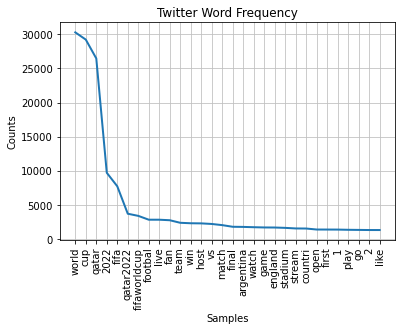

In [4]:
twitter_fd.plot(30, title = "Twitter Word Frequency");

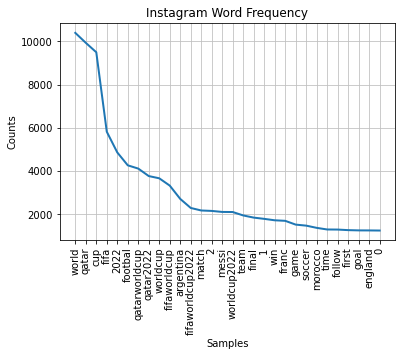

In [5]:
instagram_fd.plot(30, title = "Instagram Word Frequency");

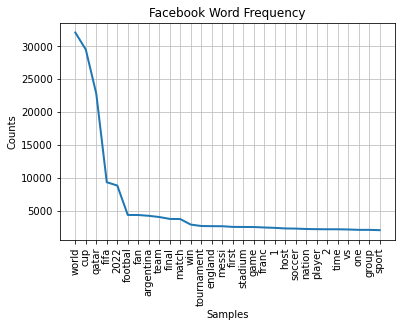

In [6]:
facebook_fd.plot(30, title = "Facebook Word Frequency");

In [7]:
twitter_text = nltk.Text(twitter_corpus)

In [8]:
#pip install gensim

In [9]:
from gensim import corpora, models

#CREATE A DICTIONARY OF TWEETS
dictionary = corpora.Dictionary(twitter.tokens) 
#REMOVE EXTREMES
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) 
#CONVERT TO BAG OF WORDS CORPUS
bow_corpus = [dictionary.doc2bow(doc) for doc in twitter.tokens]

#CREATE TF-IDF CORPUS FOR LDA MODELLING
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [10]:
#CREATE LDA MODEL FROM BOW CORPUS
lda_model = models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2, random_state=42)

In [11]:
#PRINT EACH TOPIC FROM THE LDA MODEL
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.076*"2022" + 0.057*"fifa" + 0.057*"live" + 0.041*"vs" + 0.030*"fifaworldcup" + 0.027*"stream" + 0.022*"argentina" + 0.022*"qatar2022" + 0.016*"link" + 0.014*"final"
Topic: 1 
Words: 0.022*"first" + 0.019*"game" + 0.016*"fan" + 0.015*"match" + 0.015*"ecuador" + 0.015*"host" + 0.014*"fifa" + 0.013*"2022" + 0.012*"stadium" + 0.012*"open"
Topic: 2 
Words: 0.049*"2022" + 0.023*"fifa" + 0.014*"team" + 0.014*"fan" + 0.013*"footbal" + 0.011*"group" + 0.011*"fifaworldcup" + 0.010*"belgium" + 0.010*"match" + 0.010*"news"
Topic: 3 
Words: 0.030*"die" + 0.028*"grant" + 0.028*"wahl" + 0.025*"journalist" + 0.021*"soccer" + 0.019*"cover" + 0.018*"fan" + 0.015*"2022" + 0.013*"fifa" + 0.010*"us"
Topic: 4 
Words: 0.040*"worker" + 0.029*"migrant" + 0.026*"2022" + 0.024*"fifa" + 0.015*"death" + 0.013*"die" + 0.011*"right" + 0.010*"build" + 0.008*"win" + 0.008*"human"
Topic: 5 
Words: 0.028*"2022" + 0.017*"2" + 0.016*"1" + 0.013*"goal" + 0.011*"fifa" + 0.011*"brazil" + 0.010*"qatar2022" 

In [12]:
#EXAMPLE TOPIC PROBABILITIES
lda_model.get_document_topics(bow_corpus)[40]

[(0, 0.59319156), (6, 0.17548685), (9, 0.15130801)]

In [13]:
twitter.tokens[40]

['etern',
 'glori',
 'final',
 'fifa',
 'world',
 'cup',
 'qatar',
 '2022',
 'footballcultur',
 'classicshirt',
 'footballshirt',
 'classicfootballshirt',
 'adida',
 'worldcup',
 'qatar',
 'qatar2022',
 'vamosargentina',
 'argentina',
 'fifaworldcup']

In [14]:
import operator

#ASSIGN EACH TWEET ITS MOST LIKELY TOPIC
twitter_topics_list = []
for index, topic_probs in enumerate(lda_model.get_document_topics(bow_corpus)):
    likeliest_topic = max(topic_probs, key=operator.itemgetter(1))
    twitter_topics_list.append(likeliest_topic[0])
twitter['topic'] = twitter_topics_list

In [15]:
#COUNTS OF EACH TOPIC IN THE DATASET
twitter.topic.value_counts()

0     2758
13    2609
6     2374
10    1974
5     1966
8     1939
14    1820
12    1711
3     1697
2     1693
1     1658
4     1594
7     1566
9     1136
11    1013
Name: topic, dtype: int64

In [16]:
#SAVE THE MODEL TO DISK
#I don't really know where this goes, but I think it works
#I think it goes into your Anaconda3 path by default
from gensim.test.utils import datapath
fname = datapath("LDA_Twitter_15")
lda_model.save(fname)

In [17]:
for index, score in sorted(lda_model[bow_corpus[40]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))



Score: 0.593827486038208	 
Topic: 0.076*"2022" + 0.057*"fifa" + 0.057*"live" + 0.041*"vs" + 0.030*"fifaworldcup" + 0.027*"stream" + 0.022*"argentina" + 0.022*"qatar2022" + 0.016*"link" + 0.014*"final"

Score: 0.17474719882011414	 
Topic: 0.022*"qatar2022" + 0.018*"fifaworldcup" + 0.015*"final" + 0.015*"play" + 0.014*"team" + 0.013*"player" + 0.012*"group" + 0.010*"footbal" + 0.010*"franc" + 0.010*"time"

Score: 0.15141166746616364	 
Topic: 0.058*"2022" + 0.044*"fifa" + 0.012*"fan" + 0.012*"qatar2022" + 0.011*"nft" + 0.011*"footbal" + 0.011*"award" + 0.009*"fifaworldcup" + 0.009*"mistak" + 0.007*"host"


In [18]:
#EXAMPLE SENTIMENT ANALYSIS
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

tweet = twitter.iloc[121]
print(tweet.content)
sia.polarity_scores(tweet.content)['compound']

The overriding theme of this World Cup will be Fuck Qatar and Fuck FIFA for me  Forever  Fucking scumbaggery manifest 


-0.7906

In [19]:
#ASSIGNING EACH TWEET A SENTIMENT SCORE
#This takes a long time
tweet_scores = []
for index, tweet in twitter.iterrows():
    sia = SentimentIntensityAnalyzer()
    tweet_scores.append(sia.polarity_scores(tweet.content)['compound'])
twitter['sentiment'] = tweet_scores
twitter

,content,from,locatiion,date,by,likes,shares,tokens,topic,sentiment
0,Kalvin Phillips hopeful of World Cup inclusion...,myKhel com,Bengaluru,8/11/2022 10:40,myKhel com,0,0,"[kalvin, phillip, hope, world, cup, inclus, en...",6,0.5106
1,Qatar promises a carbon neutral FIFA World C...,Republic,Mumbai India,8/11/2022 10:58,Republic,10,1,"[qatar, promis, carbon, neutral, fifa, world, ...",11,-0.2702
2,Qatar s promise of carbon neutral World Cup ...,Carbon Credit Research,Worldwide,8/11/2022 11:08,Carbon Credit Research,0,0,"[qatar, promis, carbon, neutral, world, cup, r...",3,0.0258
3,Around 6 000 Argentine Fans Banned from Stadiu...,Viral Cyprus,Worldwide,8/11/2022 12:00,Viral Cyprus,0,0,"[around, 6, 000, argentin, fan, ban, stadium, ...",14,-0.4588
4,Happy World Cup Final Day Argentina to win 2...,MrX NFT,NaN,18/12/2022 16:21,MrX NFT,0,0,"[happi, world, cup, final, day, argentina, win...",5,0.8176
...,...,...,...,...,...,...,...,...,...,...
27503,FIFA World Cup 2022 Sometimes things don t go...,Daily News hunt 24,Mumbai,28/11/2022 21:24,Daily News hunt 24,0,0,"[fifa, world, cup, 2022, sometim, thing, go, w...",8,0.0772
27504,FIFA World Cup Qatar 2022 Match schedule ...,K8 Official,NaN,29/11/2022 3:13,K8 Official,5,1,"[fifa, world, cup, qatar, 2022, match, schedul...",0,0.5859
27505,Please am I only one that has not yet watched ...,Anas zurmi,Nigeria,29/11/2022 3:13,Anas zurmi,5,0,"[pleas, one, yet, watch, even, singl, match, q...",13,-0.4019
27506,This is what the FIFAWorldCup is all about ...,FIFA World Cup Stats,Global,28/11/2022 21:47,FIFA World Cup Stats,124,28,"[fifaworldcup, play, street, footbal, biggest,...",5,0.2023


In [20]:
twitter.to_csv("twitter_final.csv")

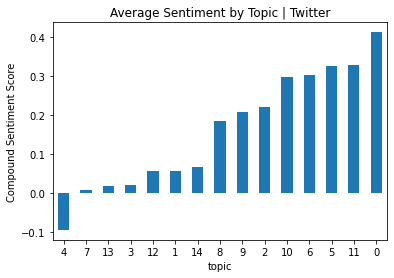

In [40]:
topic_sent = twitter.groupby(['topic']).mean().sentiment
#topic_sent.sort_values().plot()
ax = topic_sent.sort_values().plot.bar(x='lab', y='val', rot=0)
plt.title('Average Sentiment by Topic | Twitter')
plt.ylabel('Compound Sentiment Score')
plt.show()

In [60]:
twitter = twitter.rename(columns = {'date':'datetime'})
twitter['date'] = pd.to_datetime(twitter['datetime']).dt.date
twitter

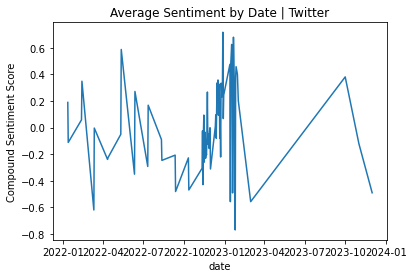

In [71]:
date_sent = twitter[twitter.topic == 4].groupby(['date']).mean().sentiment
date_sent.sort_values().plot()
plt.title('Average Sentiment by Date | Twitter')
plt.ylabel('Compound Sentiment Score')
plt.show()

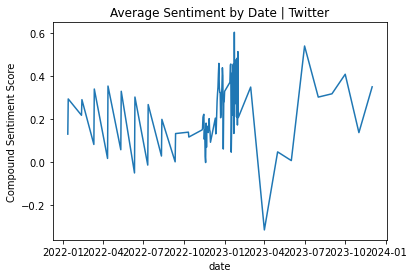

In [72]:
date_sent = twitter.groupby(['date']).mean().sentiment
date_sent.sort_values().plot()
plt.title('Average Sentiment by Date | Twitter')
plt.ylabel('Compound Sentiment Score')
plt.show()

In [22]:
lda2 = models.LdaMulticore.load(fname)